In [54]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()
import ipywidgets
from scipy.signal import butter, lfilter #Import the extra module required
from statsmodels import robust
#Define the filter

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
    
import statsmodels.api as sm

from scipy.stats import mode

In [4]:
dataPath = "C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"

trainOutput = pd.read_csv(dataPath + "challenge_fichier_de_sortie_dentrainement_classification_en_stade_de_sommeil_a_laide_de_signaux_mesures_par_le_bandeau_dreem.csv", sep=";")
Y = trainOutput["label"]

In [5]:
filetrain= dataPath + "train.h5"
filetest= dataPath + "test.h5"
h5 = h5py.File(filetrain, "r")

In [6]:
accelerometer_x = pd.DataFrame(h5['accelerometer_x'][:])
accelerometer_y = pd.DataFrame(h5['accelerometer_y'][:])
accelerometer_z = pd.DataFrame(h5['accelerometer_z'][:])


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


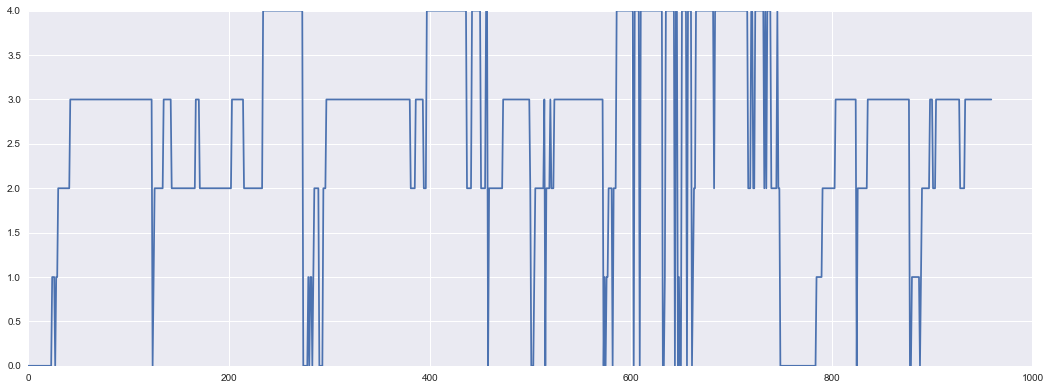

In [126]:
fig = plt.figure(figsize=(18,14))
ax1 = fig.add_subplot(211)
#ax1.set_xlabel('  time over '+ str(t))
#ax1.set_ylabel(' Density in training set')
ax1.plot(Y[0:2*60*8])
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

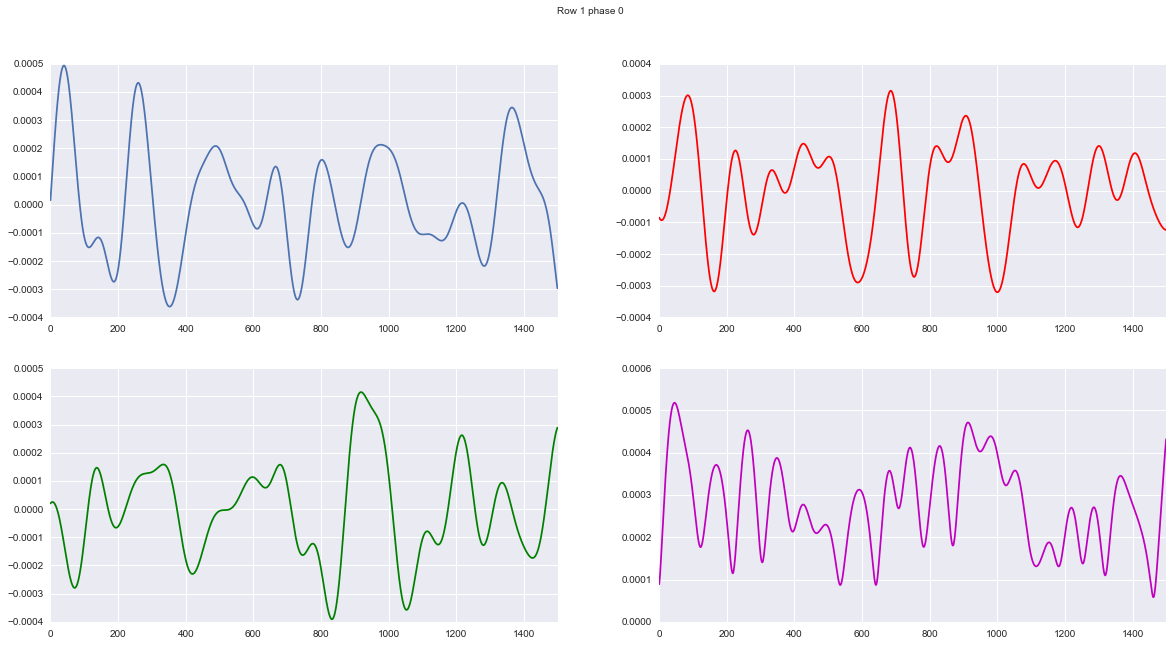

In [7]:

i = 1

fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(accelerometer_x.iloc[i])
plt.xlim(0, 1500)
plt.subplot(2,2, 2)
plt.plot(accelerometer_y.iloc[i], color = 'r')
plt.xlim(0, 1500)
plt.subplot(2,2, 3)
plt.plot(accelerometer_z.iloc[i], color ='g')
plt.xlim(0, 1500)
acc = np.sqrt(accelerometer_x.iloc[i]**2 + accelerometer_y.iloc[i]**2 + accelerometer_z.iloc[i]**2)
plt.subplot(2,2, 4)
plt.plot(acc, color ='m')
plt.xlim(0, 1500)

fig.suptitle('Row ' + str(i) + " phase " + str(Y[i]))
plt.show()

In [8]:
def get_peak(s, viz=False, avg_coef=1.2): #s is a serie
    #Calculate moving average with 0.75s in both directions, then append do dataset
    hrw = 1 #One-sided window size, as proportion of the sampling frequency
    fs = 50 #The example dataset was recorded at 50Hz (100Hz)
    mov_avg = s.rolling(int(hrw*fs)).mean() #Calculate moving average
    #print(mov_avg)

    avg_hr = np.mean(s)
    mov_avg[np.isnan(mov_avg)] = avg_hr

    mov_avg = mov_avg *  avg_coef # by we raise the average by 20% for avoiding secondary peak to interfear
    pulse_rollingmean = mov_avg 

    #Mark regions of interest
    window = []
    peaklist = []
    listpos = 0 #We use a counter to move over the different data columns
    for datapoint in s:
        rollingmean = pulse_rollingmean[listpos] #Get local mean
        if (datapoint <= rollingmean) and (len(window) <= 1): #If no detectable R-complex activity -> do nothing
            listpos += 1
        elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
            window.append(datapoint)
            listpos += 1
        else: #If signal drops below local mean -> determine highest point
            maximum = np.max(window)
            beatposition = listpos - len(window) + (window.index(np.max(window))) #Notate the position of the point on the X-axis
            peaklist.append(beatposition) #Add detected peak to list
            window = [] #Clear marked ROI
            listpos += 1
    #print(peaklist)
    
    ybeat = [s[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes
    if (viz):
        fig = plt.figure(figsize=(14, 8))
        ax1 = fig.add_subplot(211)
        ax1.set_title("Detected peaks in signal")
        ax1.set_xlim(0,1500)
        ax1.plot(s, alpha=0.5, color='blue') #Plot semi-transparent HR
        ax1.plot(mov_avg, color ='green') #Plot moving average
        ax1.scatter(peaklist, ybeat, color='red') #Plot detected peaks
        fig.show()
    return peaklist

Inspiration from  Estimating sleep parameters using an accelerometer without sleep diary

Note: accelerometer was a band wrist on non dominant arm

Arm angle was estimated as follows: 
angle = atan az/(ax^2 + ay^2).180/Pi
 where ax, ay and az are the median values of
the three orthogonally positioned raw acceleration sensors based on a rolling five second time window.
 Next, estimated arm angles were averaged per 5 second
epoch and used as input for our algorithms for detecting sleep period time (SPT-window) and sleep episodes. 

Issue: not a bandwrist 

Second metheod is is based on Euclidian norm: max(Euclidian norm -1, 0)
In our dataset Euclidian norm is in vast mak

Main literrature methods according Ancoli-Israel S, Cole R, Alessi C et al. The role of actigraphy in the study of sleep and circadian rhythms. American Academy of Sleep Medicine Review Paper. SLEEP 2003;26(3):342-92.

    The “time above threshold” strategy cumulatively counts the amount of time per epoch that the level of the signal produced in response to motion is above some threshold (commonly 0.1 to 0.2 g).
    The “zero-crossing method” counts the number of times per epoch that the activity signal level crosses zero (or very near zero).
    “Digital integration” involves sampling the accelerometry output signal at a high rate, then calculating the area under the curve for each epoch. Rectifying the analog signal doubles the amount of data available for analysis.




In [10]:
EN  = (accelerometer_x**2 +accelerometer_y**2 + accelerometer_z**2)**0.5 


In [38]:
ENY = EN.copy()
ENY["Y"] = Y
EN0 = ENY[Y==0].iloc[:, :-1]
EN1 = ENY[Y==1].iloc[:, :-1]
EN2 = ENY[Y==2].iloc[:, :-1]
EN3 = ENY[Y==3].iloc[:, :-1]
EN4 = ENY[Y==4].iloc[:, :-1]

print("EN0 mean", EN0.values.flatten().mean())
print("EN1 mean", EN1.values.flatten().mean())
print("EN2 mean", EN2.values.flatten().mean())
print("EN3 mean", EN3.values.flatten().mean())
print("EN4 mean", EN4.values.flatten().mean())
print("------------------")
print("EN0 std", EN0.values.flatten().std())
print("EN1 std", EN1.values.flatten().std())
print("EN2 std", EN2.values.flatten().std())
print("EN3 std", EN3.values.flatten().std())
print("EN4 std", EN4.values.flatten().std())



EN0 mean 0.019547807
EN1 mean 0.0036839193
EN2 mean 0.003177634
EN3 mean 0.003162502
EN4 mean 0.004072304
------------------
EN0 std 0.06335394
EN1 std 0.022298468
EN2 std 0.019877551
EN3 std 0.020605376
EN4 std 0.024484374


The “time above threshold” strategy cumulatively counts the amount of time per epoch  that the level of the signal produced in response to motion is above some threshold (commonly 0.1 to 0.2 g).

The “zero-crossing method” counts the number of times per epoch that the activity signal level crosses zero (or very near zero).
    “Digital integration” involves sampling the accelerometry output signal at a high rate, then calculating the area under the curve for each epoch. Rectifying the analog signal doubles the amount of data available for analysis.
    

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


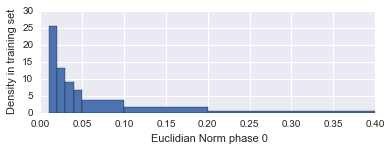

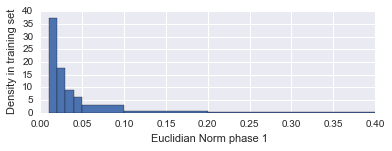

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' Euclidian Norm phase 0')
ax1.set_ylabel(' Density in training set')
plt.hist(EN0.values.flatten(), density = True, bins=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.4])
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' Euclidian Norm phase 1')
ax1.set_ylabel(' Density in training set')
plt.hist(EN1.values.flatten(), density = True, bins=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.4])
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

The “time above threshold” strategy cumulatively counts the amount of time per epoch  that the level of the signal produced in response to motion is above some threshold (commonly 0.1 to 0.2 g).
threashold = 0.01
EN2 mean 0.003177634
EN0 mean 0.019547807

In [47]:
f = EN[EN>0.01]
f.count(axis=1)/1500
0

0

In [61]:
def time_above_threshold (en, threshold):
    df = en[en>threshold]
    return df.count(axis=1)/1500

In [119]:
t = 0.005
tat = time_above_threshold(EN, t)
tatY= pd.DataFrame()
tatY["tat"]= tat
tatY["Y"]= Y

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


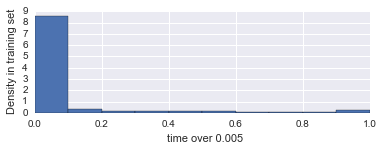

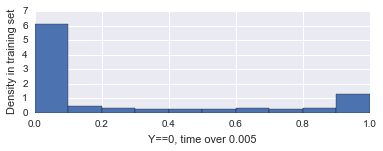

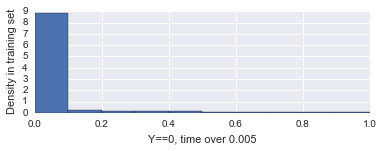

In [120]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('  time over '+ str(t))
ax1.set_ylabel(' Density in training set')
plt.hist(tat, density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Y==0, time over ' + str(t))
ax1.set_ylabel(' Density in training set')
plt.hist(tatY[Y==0].loc[:, "tat"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Y==0, time over ' + str(t))
ax1.set_ylabel(' Density in training set')
plt.hist(tatY[Y!=0].loc[:, "tat"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

The “zero-crossing method” counts the number of times per epoch that the activity signal level crosses zero (or very near zero)
thresholf: 0.003

In [92]:
def zero_crossing(en, threshold):
    r = pd.Series()
    for i in range(0, en.shape[0]):
        acc=0
        for j in range(1, en.shape[1]):
            if ((en.iloc[i,j-1] > threshold) and (en.iloc[i,j] <= threshold)):
                acc = acc+1
        r.loc[i] = acc
    return r
        

In [82]:
%timeit zen =  zero_crossing(EN, 0.003)

12min 37s ± 3.57 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
zen =  zero_crossing(EN, 0.003)

In [103]:
zenY= pd.DataFrame()
zenY["zc"] = zen
zenY["Y"]= Y

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


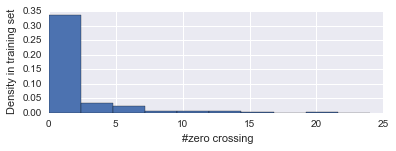

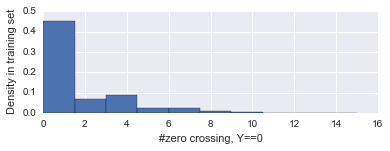

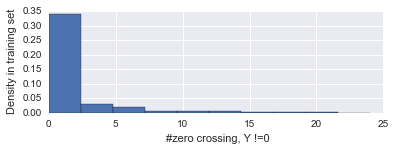

In [114]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' #zero crossing')
ax1.set_ylabel(' Density in training set')
plt.hist(zen, density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' #zero crossing, Y==0 ')
ax1.set_ylabel(' Density in training set')
plt.hist(zenY[Y==0].loc[:, "zc"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' #zero crossing, Y !=0')
ax1.set_ylabel(' Density in training set')
plt.hist(zenY[Y!=0].loc[:, "zc"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

 “Digital integration” involves sampling the accelerometry output signal at a high rate, then calculating the area under the curve for each epoch. Rectifying the analog signal doubles the amount of data available for analysis.

In [98]:
def digital_integration(en):
    return en.sum(axis=1)/1500

In [ ]:
di = digital_integration(EN)

In [121]:
diY= pd.DataFrame()
diY["di"] = di
diY["Y"]= Y

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


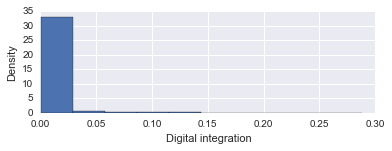

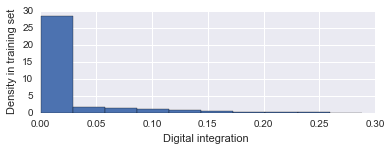

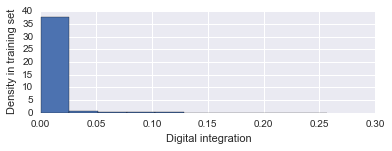

In [123]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' Digital integration')
ax1.set_ylabel('Density')
plt.hist(di, density = True)

fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Digital integration ')
ax1.set_ylabel(' Density in training set')
plt.hist(diY[Y==0].loc[:, "di"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' Digital integration')
ax1.set_ylabel(' Density in training set')
plt.hist(diY[Y!=0].loc[:, "di"], density = True)
fig.show()

In [62]:
training, test  = train_test_split(ENY, test_size=0.2, random_state=42)

In [65]:
X = pd.DataFrame(time_above_threshold(training.iloc[:,:-1], 0.01))


,0
39162,0.0
34834,0.0
17202,0.0
36243,0.0
30406,0.0


In [75]:
for k in [0.001, 0.005, 0.010, 0.015, 0.020, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:    
    X = pd.DataFrame(time_above_threshold(training.iloc[:,:-1], k))
    y = training.iloc[:,-1]
    X_test = pd.DataFrame(time_above_threshold(test.iloc[:,:-1], k))
    y_true = test.iloc[:,-1]

    dtc = RandomForestClassifier(n_estimators=100)
    

    r1 = list(range(1, 100, 10))
    r2 = list(range(2, 100, 10))
    parametres = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], "min_samples_leaf" : r1,  
                "random_state": [42], "min_samples_split" : r2}

    ck_score = make_scorer(cohen_kappa_score)
    grid = GridSearchCV(estimator=dtc,param_grid=parametres,scoring=ck_score, n_jobs=-2)

    grid_fitted = grid.fit(X,y)
    print(grid_fitted.best_params_)

    y_pred = grid.predict(X_test)
    print("Theshold: ", k)
    print("kappa: ", cohen_kappa_score(y_true, y_pred))
    print("accurancy: ", accuracy_score(y_true, y_pred))
    print("-----------")

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 62, 'random_state': 42}
Theshold:  0.001
kappa:  0.05228157397710409
accurancy:  0.3864932694501483
-----------
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}
Theshold:  0.005
kappa:  0.05045314319368743
accurancy:  0.39082819986310746
-----------
{'max_depth': 8, 'min_samples_leaf': 61, 'min_samples_split': 2, 'random_state': 42}
Theshold:  0.01
kappa:  0.04307676888936207
accurancy:  0.38717773214693135
-----------
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}
Theshold:  0.015
kappa:  0.03436285342343737
accurancy:  0.3882044261921059
-----------
{'max_depth': 2, 'min_samples_leaf': 21, 'min_samples_split': 2, 'random_state': 42}
Theshold:  0.02
kappa:  0.057983817117859715
accurancy:  0.38501026694045176
-----------
{'max_depth': 2, 'min_samples_leaf': 21, 'min_samples_split': 2, 'random_state': 42}
Theshold:  0.05
kappa:  0.05404446718222822
accura

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


[45, 169, 262, 348, 426, 591, 742, 829, 913, 1153, 1219, 1285, 1364]

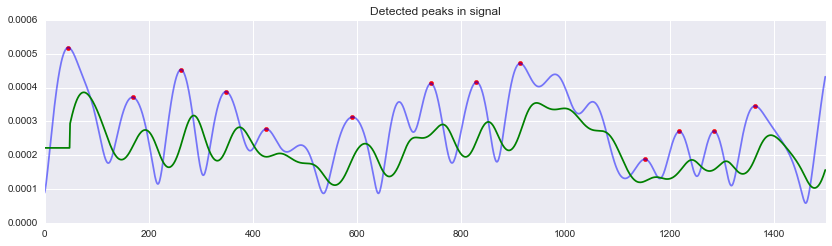

In [48]:
get_peak(EN.iloc[1, :], viz=True)

In [20]:
T_EN = pd.DataFrame()
for i in range(1000):
   T_EN.loc[i, "T"] = len(get_peak(EN.iloc[i, :])) 


In [129]:
Angle_Z = np.arctan(accelerometer_z/(accelerometer_x**2 +accelerometer_y**2))*180/np.pi
Angle_Y = np.arctan(accelerometer_y/(accelerometer_x**2 +accelerometer_z**2))*180/np.pi
Angle_X = np.arctan(accelerometer_x/(accelerometer_z**2 +accelerometer_y**2))*180/np.pi
Angle_Z["Y"]=Y
Angle_Y["Y"]=Y
Angle_X["Y"]=Y

In [134]:
Angle = pd.DataFrame()

for i in range(1000):
    x = Angle_X.iloc[i, :1500]
    y = Angle_Y.iloc[i, :1500]
    z = Angle_Z.iloc[i, :1500]

    Angle.loc[i, "Ax"] = len(get_peak(x))
    Angle.loc[i, "Ay"] = len(get_peak(y))
    Angle.loc[i, "Az"] = len(get_peak(z))

In [139]:
from scipy.stats.stats import pearsonr  
print("corelation Angle X and Angle Y", pearsonr(Angle["Ax"], Angle["Ay"]))
print("corelation Angle X and Angle Z", pearsonr(Angle["Ax"], Angle["Az"]))
print("corelation Angle Y and Angle Z", pearsonr(Angle["Ay"], Angle["Az"]))
      

corelation Angle X and Angle Y (0.5395189964431983, 1.3091715462139678e-76)
corelation Angle X and Angle Z (0.5693179620464055, 5.6233482447310645e-87)
corelation Angle Y and Angle Z (0.5147133081429992, 9.718213298276248e-69)


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


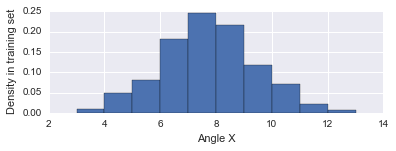

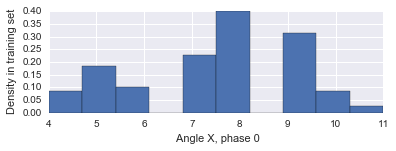

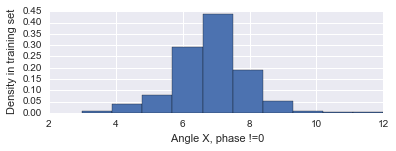

In [150]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Angle X')
ax1.set_ylabel(' Density in training set')
plt.hist(Angle["Ax"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' Angle X, phase 0')
ax1.set_ylabel(' Density in training set')
plt.hist(Angle[Y==0]["Ax"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' Angle X, phase !=0')
ax1.set_ylabel(' Density in training set')
plt.hist(Angle[Y!=0]["Ax"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

Main literrature methods according Ancoli-Israel S, Cole R, Alessi C et al. The role of actigraphy in the study of sleep and circadian rhythms. American Academy of Sleep Medicine
Review Paper. SLEEP 2003;26(3):342-92.
- The “time above threshold” strategy cumulatively counts the amount
of time per epoch that the level of the signal produced in response to
motion is above some threshold (commonly 0.1 to 0.2 g).
- The “zero-crossing method” counts the number of times per epoch
that the activity signal level crosses zero (or very near zero).
- “Digital integration” involves sampling the accelerometry output signal
at a high rate, then calculating the area under the curve for each
epoch. Rectifying the analog signal doubles the amount of data available
for analysis.

In [157]:
def make_acc_features(h5filename, dataPath="C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"):
    print("Read data")
    h5file= dataPath + h5filename
    h5 = h5py.File(h5file, "r")
    accelerometer_x = pd.DataFrame(h5['accelerometer_x'][:])
    accelerometer_y = pd.DataFrame(h5['accelerometer_y'][:])
    accelerometer_z = pd.DataFrame(h5['accelerometer_z'][:])
    
    features = pd.DataFrame()
    
    print("Euclidian Norm")
    EN  = (accelerometer_x**2 +accelerometer_y**2 + accelerometer_z**2)**0.5
    di = digital_integration(EN)
    zc = zero_crossing(EN, 0.003)
    t = 0.01
    tat = time_above_threshold(EN, t)
    features["di"] = di
    features["zc"] = zc
    features["tat"] = tat
    
    print("Angles")
    Angle_Z = np.arctan(accelerometer_z/(accelerometer_x**2 +accelerometer_y**2))*180/np.pi
    Angle_Y = np.arctan(accelerometer_y/(accelerometer_x**2 +accelerometer_z**2))*180/np.pi
    Angle_X = np.arctan(accelerometer_x/(accelerometer_z**2 +accelerometer_y**2))*180/np.pi
    
    phi = np.arccos(accelerometer_z/EN) * 180/np.pi
    theta = np.arctan(accelerometer_y/accelerometer_x) *180/np.pi

    
    for i in range(0, accelerometer_z.shape[0]):
        x = Angle_X.iloc[i, :]
        y = Angle_Y.iloc[i, :]
        z = Angle_Z.iloc[i, :]
        p = phi.iloc[i, :]
        t = theta.iloc[i, :]

        features.loc[i, "Ax"] = len(get_peak(x))
        features.loc[i, "Ay"] = len(get_peak(y))
        features.loc[i, "Az"] = len(get_peak(z))
        features.loc[i, "phi"] = len(get_peak(p))
        features.loc[i, "theta"] = len(get_peak(t))
    return features

In [158]:
acc_train = make_acc_features("train.h5")
#acc_train.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTrain.xlsx')



Read data
Euclidian Norm
Angles


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


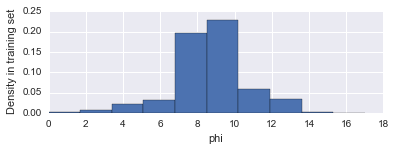

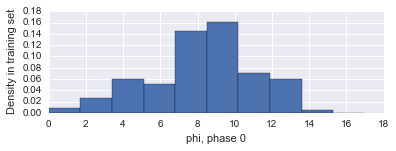

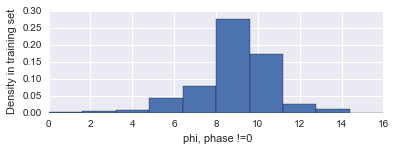

In [160]:
#s= features["phi"]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('phi')
ax1.set_ylabel(' Density in training set')
plt.hist(acc_train["phi"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('phi, phase 0')
ax1.set_ylabel(' Density in training set')
plt.hist(acc_train[Y==0]["phi"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' phi, phase !=0')
ax1.set_ylabel(' Density in training set')
plt.hist(acc_train[Y!=0]["phi"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


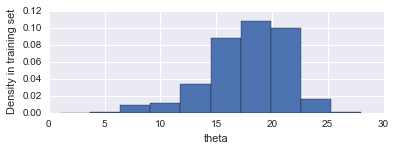

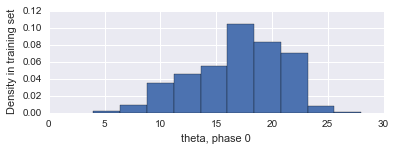

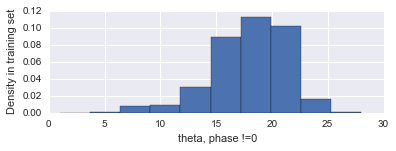

In [161]:
#s= features["phi"]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('theta')
ax1.set_ylabel(' Density in training set')
plt.hist(acc_train["theta"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('theta, phase 0')
ax1.set_ylabel(' Density in training set')
plt.hist(acc_train[Y==0]["theta"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' theta, phase !=0')
ax1.set_ylabel(' Density in training set')
plt.hist(acc_train[Y!=0]["theta"], density = True)
#ax1.set_xlim((low, up))
#ax1.set_title('Euclidian norm max')
fig.show()

In [159]:
acc_test = make_acc_features("test.h5")
#acc_test.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTest.xlsx')


Read data
Euclidian Norm
Angles
